In [ ]:
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import kerastuner as kt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Dataset Ikan",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 3778 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
print(class_names)

['Fresh', 'Not Fresh']


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
def build_model(hp):
    resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    n_classes = 2

    model = tf.keras.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'),
        layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
        layers.Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=EPOCHS,
    factor=3,
    directory='tuner_directory',
    project_name='fish_classification'
)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [ ]:
tuner.search(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping])


Trial 90 Complete [00h 01m 12s]
val_accuracy: 0.5511363744735718

Best val_accuracy So Far: 0.84375
Total elapsed time: 01h 16m 09s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
best_model = tuner.hypermodel.build(best_hps)


In [ ]:
history = best_model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)


Epoch 1/50
95/95 [==============================] - 8s 49ms/step - loss: 0.6547 - accuracy: 0.6113 - val_loss: 0.5703 - val_accuracy: 0.6960
Epoch 2/50
95/95 [==============================] - 4s 45ms/step - loss: 0.5935 - accuracy: 0.6864 - val_loss: 0.6193 - val_accuracy: 0.7159
Epoch 3/50
95/95 [==============================] - 4s 46ms/step - loss: 0.5576 - accuracy: 0.7116 - val_loss: 0.5006 - val_accuracy: 0.7301
Epoch 4/50
95/95 [==============================] - 4s 46ms/step - loss: 0.5220 - accuracy: 0.7355 - val_loss: 0.4792 - val_accuracy: 0.7415
Epoch 5/50
95/95 [==============================] - 4s 46ms/step - loss: 0.4999 - accuracy: 0.7442 - val_loss: 0.4818 - val_accuracy: 0.7472
Epoch 6/50
95/95 [==============================] - 5s 48ms/step - loss: 0.4895 - accuracy: 0.7432 - val_loss: 0.4425 - val_accuracy: 0.7812
Epoch 7/50
95/95 [==============================] - 4s 47ms/step - loss: 0.4790 - accuracy: 0.7535 - val_loss: 0.4548 - val_accuracy: 0.7585
Epoch 8/50
95

In [ ]:
scores = best_model.evaluate(test_ds)

13/13 [==============================] - 12s 25ms/step - loss: 0.2992 - accuracy: 0.8582


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

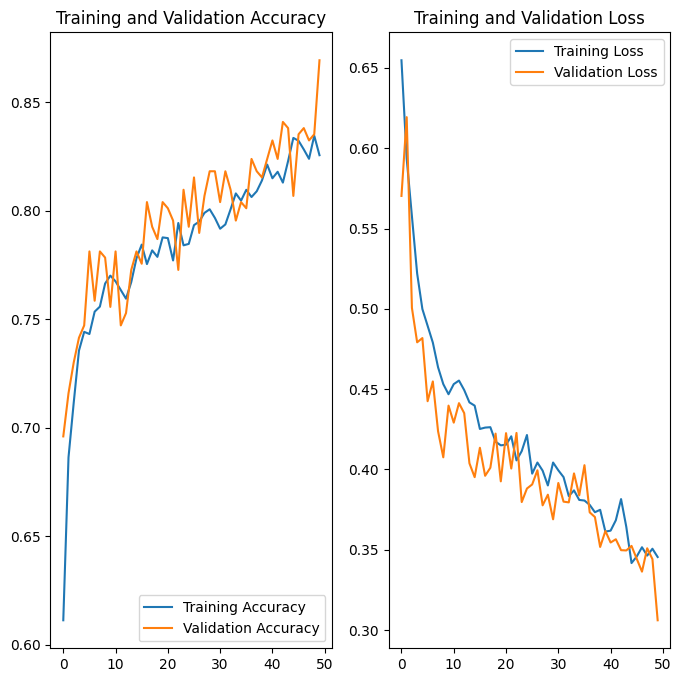

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


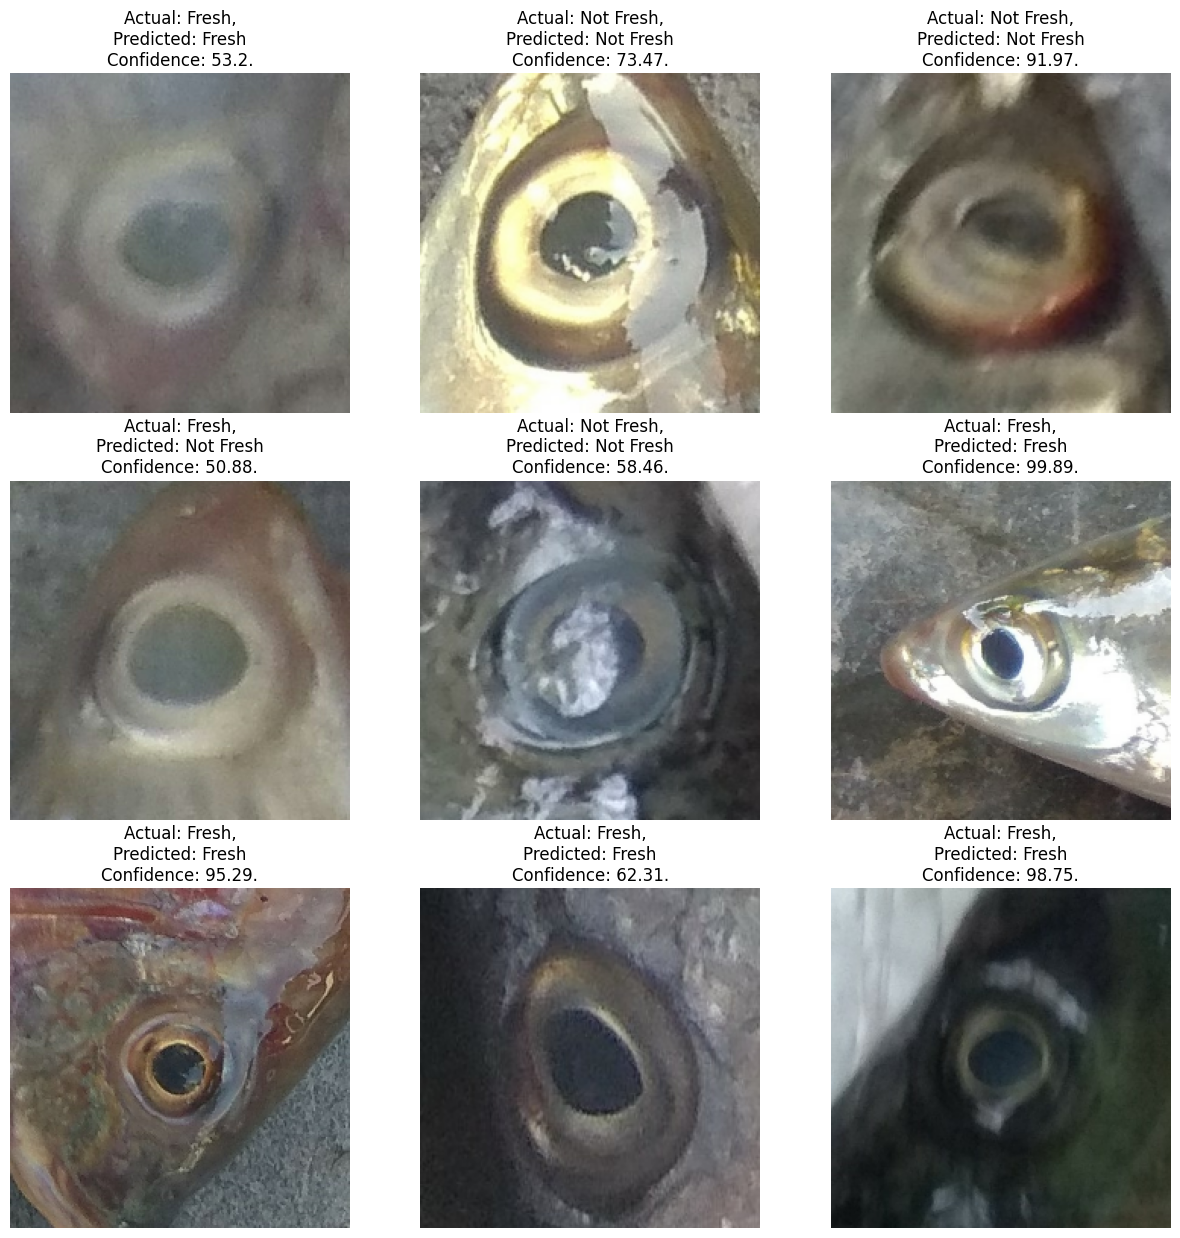

In [ ]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(best_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}\nConfidence: {confidence}.")

        plt.axis("off")

In [ ]:
model_version=1
best_model.save(f"models")
best_model.save("models.h5")
best_model.save("models.tflite")

In [ ]:
# Misalkan test_ds adalah dataset yang berisi data uji
# Anda bisa mengganti test_ds sesuai dengan variabel yang Anda miliki

y_true = []  # Label sebenarnya
y_pred = []  # Label prediksi

for images, labels in test_ds:
    predictions = best_model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Konversi label menjadi nama kelas
class_names = dataset.class_names
y_true = [class_names[label] for label in y_true]
y_pred = [class_names[label] for label in y_pred]
print(classification_report(y_true, y_pred))

1/1 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

       Fresh       0.83      0.92      0.87       217
   Not Fresh       0.90      0.79      0.84       199

    accuracy                           0.86       416
   macro avg       0.86      0.86      0.86       416
weighted avg       0.86      0.86      0.86       416



In [ ]:
# Menggunakan LabelEncoder untuk mengubah label string menjadi bilangan bulat
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

# Membuat confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[199  18]
 [ 41 158]]


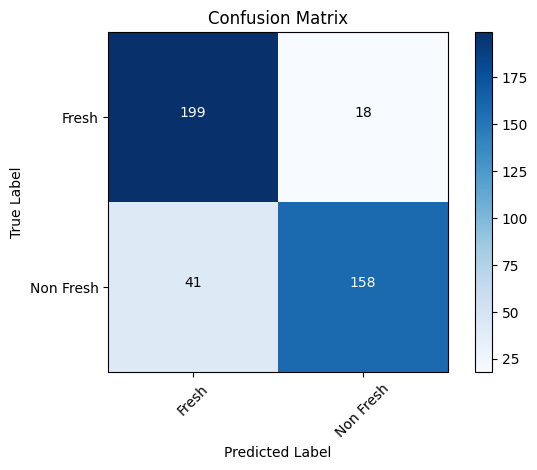

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Menentukan label kelas
class_names = ["Fresh", "Non Fresh"]

# Menentukan confusion matrix
cm = np.array([[199, 18], [41, 158]])

# Membuat plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Menampilkan label pada sumbu x dan y
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Menampilkan angka di dalam kotak confusion matrix
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

# Menampilkan sumbu x dan y
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Menampilkan plot
plt.tight_layout()
plt.show()